In [1]:
# install.packages("sp")
# install.packages("rgdal")
# install.packages("rgeos")
# install.packages("tmap")
# install.packages("raster")
# install.packages("spdep")
# install.packages("gstat")
# install.packages("spgwr")
# install.packages("GWmodel")
# install.packages("regclass")
# install.packages("ggplot2")
# install.packages("ggcorrplot")
# install.packages("lmtest")
# install.packages("stringr")
# install.packages("leaflet")
# install.packages("extrafont") 

library(sp)
library(dplyr)
library(stringr)
library(rgeos)
library(tmap)
library(raster)
library(spdep)
library(gstat)
library(spgwr)
library(GWmodel)
library(regclass)
library(ggplot2)
library(ggcorrplot)
library(lmtest)
library(leaflet)
library(extrafont)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


rgeos version: 0.5-3, (SVN revision 634)
 GEOS runtime version: 3.8.0-CAPI-1.13.1 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 



Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.1.2, PROJ 6.1.0

NOTE: This package does not constitute approval of GWR
as a method of spatial analysis; see example(gwr)

Loading required package: maptools

Checking rgeos availability: TRUE

Loading required package: robustbase

Loading required package: Rcpp

Loading required package: spat

## 현재까지 구축한 데이터 불러오기

데이터의 양이 충분하지 않는 '중앙분리대수' 변수는 제외하기

In [2]:
acci_count_filter25 <- read.csv("accident_count_filter_25.csv" ) %>% dplyr::select(-중앙분리대수)
dim(acci_count_filter25)
acci_count_filter25 %>% head(1)

[1] 5556   48

,X,gid,acci_cnt,geometry,사고건수,사상자수,x,y,신호등_보행자수,신호등_차량등수,⋯,차대사람..60대.이상,차대차..20대,차대차..20대.미만,차대차..30대,차대차..40대,차대차..50대,차대차..60대.이상,사망자수,경상자수,중상자수
,<int>,<fct>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,다바931203,2,"MULTIPOLYGON (((127.4230710131166 36.38013455218083, 127.4230701251944 36.38103608833949, 127.4241850500282 36.38103680113275, 127.424185925082 36.38013526495075, 127.4230710131166 36.38013455218083)))",2,2,127.4236,36.38059,1,3,⋯,1,0,0,0,1,0,0,0,1,1


In [3]:
names(acci_count_filter25)

[1] "X"                            "gid"                         
 [3] "acci_cnt"                     "geometry"                    
 [5] "사고건수"                     "사상자수"                    
 [7] "x"                            "y"                           
 [9] "신호등_보행자수"              "신호등_차량등수"             
[11] "cctv수"                       "혼잡빈도강도"                
[13] "혼잡시간강도"                 "전체_추정교통량"             
[15] "이상평균기온동반사고건수"     "이상최저온도동반사고건수"    
[17] "이상최고온도동반사고건수"     "이상최대풍속동반사고건수"    
[19] "이상평균풍속동반사고건수"     "이상평균습도동반사고건수"    
[21] "이상평균지면온도동반사고건수" "이상강수량동반사고건수"      
[23] "이상적설량동반사고건수"       "이상안개시간동반사고건수"    
[25] "안전지대수"                   "정차금지지대수"              
[27] "도로속도표시수"               "교통안전표지수"              
[29] "노드개수"                     "횡단보도수"                  
[31] "건물면적"                     "자동차대수"                  
[33] "총거주인구수"                 "차대사람..20대"              
[35] "차대사람..20대.미만"          "차대사람..30대"              
[37] "차대사람..40대"               "차대사람..50대"              
[39] "차대사람..60대.이상"          "차대차..20대"                
[41] "차대차..20대.미만"            "차대차..30대"                
[43] "차대차..40대"                 "차대차..50대"                
[45] "차대차..60대.이상"            "사망자수"                    
[47] "경상자수"                     "중상자수"

#### 변수 필터링 과정1 - 상관행렬과 Heatmap 확인

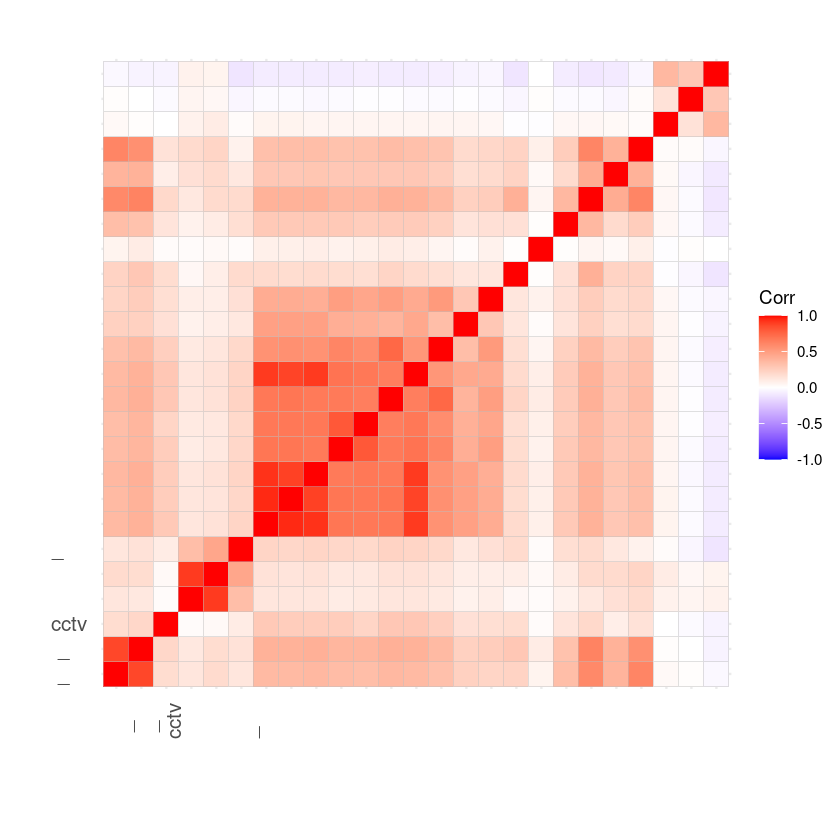

In [4]:
# 상관행렬
check_cor <- acci_count_filter25 %>% dplyr::select(`신호등_보행자수`:총거주인구수) %>% cor()

# Heatmap
check_cor2 <- acci_count_filter25 %>% dplyr::select(`신호등_보행자수`:총거주인구수) %>% 
                cor()%>% ggcorrplot(tl.srt = 90)
check_cor2

#### 변수 필터링 과정2 - 분산팽창인자(VIF) 확인

In [5]:
check_cor_df <- acci_count_filter25 %>% dplyr::select(`신호등_보행자수`:총거주인구수, 전체_추정교통량,사고건수)

mod1 <- lm(사고건수 ~ ., data=check_cor_df)
vif <- VIF(mod1)
print("다중공선성 존재")
names(vif)[vif > 5]; # 다중공선성 있다고 판단되는 독립변수들

print("다중공선성이 존재하지 않음")
names(vif)[vif < 5]; # 다중공선성이 있다고 판단되지는 않는 변수들(정상적인 변수들)

[1] "다중공선성 존재"


[1] "혼잡빈도강도"                 "혼잡시간강도"                
[3] "이상평균기온동반사고건수"     "이상최저온도동반사고건수"    
[5] "이상최고온도동반사고건수"     "이상평균지면온도동반사고건수"

[1] "다중공선성이 존재하지 않음"


[1] "신호등_보행자수"          "신호등_차량등수"         
 [3] "cctv수"                   "전체_추정교통량"         
 [5] "이상최대풍속동반사고건수" "이상평균풍속동반사고건수"
 [7] "이상평균습도동반사고건수" "이상강수량동반사고건수"  
 [9] "이상적설량동반사고건수"   "이상안개시간동반사고건수"
[11] "안전지대수"               "정차금지지대수"          
[13] "도로속도표시수"           "교통안전표지수"          
[15] "노드개수"                 "횡단보도수"              
[17] "건물면적"                 "자동차대수"              
[19] "총거주인구수"

**혼잡빈도강도, 혼잡시간강도, 이상평균기온동반사고건수, 이상최저온도동반사고건수, 이상최고온도동반사고건수, 이상평균지면온도동반사고건수**는 vif가 5 이상으로 판별되었다.<br/>
- 데이터 변형1 : 혼잡빈도강도, 혼잡시간강도 데이터의 평균을 "평균혼잡강도" 데이터로 수정
- 데이터 변형2 : 평균기온동반사고건수, 최저온도동반사고건수, 최고온도동반사고건수, 평균지면온도동반사고건수 변수들의 상관관계가 높아 "이상평균기온동반사고건수"만 사용

In [6]:
revised_df <- acci_count_filter25 %>% mutate(평균혼잡강도=(혼잡빈도강도+혼잡시간강도)/2)%>%
  dplyr::select(-이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수, -혼잡빈도강도, -혼잡시간강도)

# VIF 확인
check_cor_df2 <- revised_df %>% dplyr::select(`신호등_보행자수`:총거주인구수, 전체_추정교통량, 사고건수)
mod2 <- lm(사고건수 ~ ., data=check_cor_df2)
vif_final <- VIF(mod2)

print("다중공선성 존재")
names(vif_final)[vif_final>5]; # 다중공선성 있다고 판단되는 독립변수들

print("다중공선성이 존재하지 않음")
names(vif_final)[vif_final<5]; # 다중공선성이 있다고 판단되지는 않는 변수들(정상적인 변수들)

[1] "다중공선성 존재"


character(0)

[1] "다중공선성이 존재하지 않음"


[1] "신호등_보행자수"          "신호등_차량등수"         
 [3] "cctv수"                   "전체_추정교통량"         
 [5] "이상평균기온동반사고건수" "이상최대풍속동반사고건수"
 [7] "이상평균풍속동반사고건수" "이상평균습도동반사고건수"
 [9] "이상강수량동반사고건수"   "이상적설량동반사고건수"  
[11] "이상안개시간동반사고건수" "안전지대수"              
[13] "정차금지지대수"           "도로속도표시수"          
[15] "교통안전표지수"           "노드개수"                
[17] "횡단보도수"               "건물면적"                
[19] "자동차대수"               "총거주인구수"

# <font color=blue>1. OLS 모델링</font>

In [7]:
car_under20 <- read.csv("car_under20.csv", row.names = 1)
car_20 <- read.csv("car_20.csv", row.names = 1)
car_30 <- read.csv("car_30.csv", row.names = 1)
car_40 <- read.csv("car_40.csv", row.names = 1)
car_50 <- read.csv("car_50.csv", row.names = 1)
car_over60 <- read.csv("car_over60.csv", row.names = 1)

person_under20 <- read.csv("person_under20.csv", row.names = 1)
person_20 <- read.csv("person_20.csv", row.names = 1)
person_30 <- read.csv("person_30.csv", row.names = 1)
person_40 <- read.csv("person_40.csv", row.names = 1)
person_50 <- read.csv("person_50.csv", row.names = 1)
person_over60 <- read.csv("person_over60.csv", row.names = 1)

##### OLS 모델 적용 - 차대사람..60대 이상

In [8]:
mod_data2 <- person_over60 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..60대.이상) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..60대.이상`~., mod_data2)
# 회귀분석의 변수선택(stepwise 방법)
summary(step(mod,direction = 'both'))
mod1 <- lm(formula = 차대사람..60대.이상 ~ 이상평균기온동반사고건수 + 
           이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상안개시간동반사고건수 + 
           안전지대수 + 횡단보도수 + 자동차대수 + 평균혼잡강도, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)

Start:  AIC=-2179.02
차대사람..60대.이상 ~ 신호등_보행자수 + 신호등_차량등수 + 
    cctv수 + 전체_추정교통량 + 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 정차금지지대수 + 도로속도표시수 + 
    교통안전표지수 + 노드개수 + 횡단보도수 + 
    건물면적 + 자동차대수 + 총거주인구수 + 평균혼잡강도

                           Df Sum of Sq    RSS     AIC
- 노드개수                  1    0.0003 1083.7 -2181.0
- 이상최대풍속동반사고건수  1    0.0025 1083.7 -2181.0
- 도로속도표시수            1    0.0385 1083.7 -2180.9
- cctv수                    1    0.0717 1083.8 -2180.8
- 건물면적                  1    0.0849 1083.8 -2180.8
- 총거주인구수              1    0.1840 1083.9 -2180.6
- 정차금지지대수            1    0.1845 1083.9 -2180.6
- 교통안전표지수            1    0.3261 1084.0 -2180.2
- 신호등_보행자수           1    0.3281 1084.0 -2180.2
- 이상강수량동반사고건수    1    0.4102 1084.1 -2180.0
<none>                                  1083.7 -2179.0
- 이상적설량동반사고건수    1    0.9596 1084.7 -2178.7
- 자동차대수                1    0.9730 1084.7 -2178.7
- 이상평균풍속동반사고


Call:
lm(formula = 차대사람..60대.이상 ~ 전체_추정교통량 + 
    이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 횡단보도수 + 평균혼잡강도, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7862 -0.3834 -0.2401  0.4636  5.1878 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.879e-01  2.121e-02   8.859  < 2e-16 ***
전체_추정교통량          -7.376e-05  2.917e-05  -2.529  0.01151 *  
이상평균기온동반사고건수  5.352e-02  1.217e-02   4.398 1.13e-05 ***
이상평균풍속동반사고건수  2.810e-02  1.271e-02   2.211  0.02712 *  
이상평균습도동반사고건수  5.222e-02  1.247e-02   4.186 2.93e-05 ***
이상안개시간동반사고건수  6.832e-02  2.683e-02   2.546  0.01094 *  
안전지대수               -5.131e-02  1.643e-02  -3.123  0.00181 ** 
횡단보도수                6.029e-02  8.067e-03   7.474 1.06e-13 ***
평균혼잡강도              1.171e-03  4.048e-04   2.894  0.00384 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6515 on 2563 degrees of 


Call:
lm(formula = 차대사람..60대.이상 ~ 이상평균기온동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상안개시간동반사고건수 + 안전지대수 + 
    횡단보도수 + 자동차대수 + 평균혼잡강도, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7738 -0.3846 -0.2353  0.4581  5.2339 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               1.760e-01  2.168e-02   8.118 7.30e-16 ***
이상평균기온동반사고건수  5.272e-02  1.217e-02   4.332 1.54e-05 ***
이상평균풍속동반사고건수  2.638e-02  1.271e-02   2.075 0.038042 *  
이상평균습도동반사고건수  5.028e-02  1.246e-02   4.035 5.61e-05 ***
이상안개시간동반사고건수  6.638e-02  2.684e-02   2.473 0.013444 *  
안전지대수               -5.758e-02  1.621e-02  -3.553 0.000387 ***
횡단보도수                6.225e-02  8.039e-03   7.743 1.38e-14 ***
자동차대수                1.199e-04  8.116e-05   1.478 0.139617    
평균혼잡강도              6.922e-04  3.596e-04   1.925 0.054337 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6521 on 2563 degrees of f

[1] "AIC: 5110.27"


	studentized Breusch-Pagan test

data:  mod1
BP = 164.15, df = 8, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9994, p-value = 0.492
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.85343, p-value < 2.2e-16


##### OLS 모델 적용 - 차대사람..50대

In [9]:
mod_data2 <- person_50 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..50대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..50대`~., mod_data2)
# summary(step(mod,direction = 'both'))
mod1 <- lm(formula = 차대사람..50대 ~ 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
           이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
           안전지대수 + 횡단보도수, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대사람..50대 ~ 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    안전지대수 + 횡단보도수, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3787 -0.2436 -0.1351 -0.0939  4.6271 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.094128   0.014437   6.520 8.53e-11 ***
이상평균기온동반사고건수  0.040988   0.009598   4.270 2.03e-05 ***
이상최대풍속동반사고건수 -0.031677   0.012793  -2.476  0.01335 *  
이상평균풍속동반사고건수  0.032998   0.012695   2.599  0.00940 ** 
이상평균습도동반사고건수  0.042206   0.010893   3.874  0.00011 ***
이상강수량동반사고건수    0.023483   0.016125   1.456  0.14543    
안전지대수               -0.042432   0.012941  -3.279  0.00106 ** 
횡단보도수                0.037372   0.005919   6.314 3.23e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4836 on 2405 degrees of freedom
Multiple R-squared:  0.1168,	Adjusted R-squared:  0.1142 
F-statistic: 45.44

[1] "AIC: 3351.22"


	studentized Breusch-Pagan test

data:  mod1
BP = 130.45, df = 7, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 2.0242, p-value = 0.7235
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.75623, p-value < 2.2e-16


##### OLS 모델 적용 - 차대사람..40대

In [10]:
mod_data2 <- person_40 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..40대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..40대`~., mod_data2)
# summary(step(mod,direction = 'both'))
mod1 <- lm(formula = 차대사람..40대 ~ 신호등_보행자수 + 신호등_차량등수 + 
           이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 이상강수량동반사고건수 + 
           이상적설량동반사고건수 + 도로속도표시수 + 횡단보도수 + 전체_추정교통량 + 
           평균혼잡강도, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대사람..40대 ~ 신호등_보행자수 + 신호등_차량등수 + 
    이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    도로속도표시수 + 횡단보도수 + 전체_추정교통량 + 
    평균혼잡강도, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2402 -0.2015 -0.1260 -0.0723  3.3554 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               7.231e-02  1.510e-02   4.791 1.77e-06 ***
신호등_보행자수           1.839e-02  9.432e-03   1.950 0.051305 .  
신호등_차량등수          -1.445e-02  6.196e-03  -2.332 0.019766 *  
이상평균기온동반사고건수  2.670e-02  8.561e-03   3.118 0.001841 ** 
이상최대풍속동반사고건수  2.107e-02  9.200e-03   2.290 0.022130 *  
이상강수량동반사고건수    4.544e-02  1.269e-02   3.582 0.000348 ***
이상적설량동반사고건수    4.251e-02  2.314e-02   1.837 0.066332 .  
도로속도표시수           -8.829e-03  6.390e-03  -1.382 0.167228    
횡단보도수                2.671e-02  6.346e-03   4.210 2.66e-05 ***
전체_추정교통량          -2.846e-05  1.969e-05  -1.446 0.148380    
평균혼잡강도              6.909e-04  2.72

[1] "AIC: 2686.9"


	studentized Breusch-Pagan test

data:  mod1
BP = 134.96, df = 10, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9961, p-value = 0.4613
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.70634, p-value < 2.2e-16


##### OLS 모델 적용 - 차대사람..30대

In [11]:
mod_data2 <- person_30 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..30대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..30대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))

mod1 <- lm(formula = 차대사람..30대 ~ 신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
           이상최대풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
           이상적설량동반사고건수 + 정차금지지대수 + 횡단보도수 + 총거주인구수 + 
           전체_추정교통량, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대사람..30대 ~ 신호등_차량등수 + cctv수 + 
    이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상적설량동반사고건수 + 정차금지지대수 + 
    횡단보도수 + 총거주인구수 + 전체_추정교통량, 
    data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2874 -0.1793 -0.0932 -0.0339  4.2475 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.937e-02  1.621e-02   1.812  0.07014 .  
신호등_차량등수          -1.079e-02  3.969e-03  -2.718  0.00661 ** 
cctv수                   -1.234e-01  4.166e-02  -2.962  0.00309 ** 
이상평균기온동반사고건수  4.536e-02  8.801e-03   5.154 2.79e-07 ***
이상최대풍속동반사고건수  1.874e-02  9.090e-03   2.062  0.03933 *  
이상평균습도동반사고건수  1.744e-02  9.796e-03   1.781  0.07508 .  
이상강수량동반사고건수    2.678e-02  1.438e-02   1.863  0.06257 .  
이상적설량동반사고건수    4.230e-02  2.216e-02   1.908  0.05647 .  
정차금지지대수            2.147e-01  1.082e-01   1.985  0.04733 *  
횡단보도수                3.158e-02  5.981e-03   5.281 1.42e-07 ***
총거주인구수           

[1] "AIC: 2238.31"


	studentized Breusch-Pagan test

data:  mod1
BP = 196.33, df = 11, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9806, p-value = 0.3256
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.69851, p-value < 2.2e-16


##### OLS 모델 적용 - 차대사람..20대

In [12]:
mod_data2 <- person_20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..20대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..20대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))

mod1 <- lm(formula = 차대사람..20대 ~ 신호등_보행자수 + 신호등_차량등수 + 
           cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
           이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
           이상적설량동반사고건수 + 정차금지지대수 + 도로속도표시수 + 
           노드개수, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대사람..20대 ~ 신호등_보행자수 + 신호등_차량등수 + 
    cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    정차금지지대수 + 도로속도표시수 + 노드개수, 
    data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2410 -0.3240 -0.0373  0.1943 30.7123 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.03732    0.04322   0.864 0.387966    
신호등_보행자수           0.08047    0.03092   2.603 0.009320 ** 
신호등_차량등수          -0.09950    0.02183  -4.558 5.53e-06 ***
cctv수                   -0.81354    0.14882  -5.467 5.25e-08 ***
이상평균기온동반사고건수  0.22614    0.03127   7.233 7.05e-13 ***
이상최대풍속동반사고건수  0.17857    0.03872   4.612 4.28e-06 ***
이상평균풍속동반사고건수  0.06059    0.03786   1.601 0.109631    
이상평균습도동반사고건수  0.07215    0.03570   2.021 0.043410 *  
이상강수량동반사고건수   -0.16962    0.05103  -3.324 0.000906 ***
이상적설량동반사고건수    0.47577    0.07953   5.983 2.66e-09 ***
정차금지지대수            2.45718    0

[1] "AIC: 6047.79"


	studentized Breusch-Pagan test

data:  mod1
BP = 405.1, df = 12, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9891, p-value = 0.4094
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.42222, p-value < 2.2e-16


##### OLS 모델 적용 - 차대사람..20대미만

In [13]:
mod_data2 <- person_under20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..20대.미만) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대사람..20대.미만`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))

mod1 <- lm(formula = 차대사람..20대.미만 ~ 신호등_보행자수 + 신호등_차량등수 + 
           cctv수 + 이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
           이상평균습도동반사고건수 + 이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
           안전지대수 + 정차금지지대수 + 노드개수 + 횡단보도수 + 총거주인구수 + 
           전체_추정교통량, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대사람..20대.미만 ~ 신호등_보행자수 + 
    신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 정차금지지대수 + 노드개수 + 
    횡단보도수 + 총거주인구수 + 전체_추정교통량, 
    data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7979 -0.2291 -0.1247 -0.0340  8.8293 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               7.876e-02  2.054e-02   3.835 0.000129 ***
신호등_보행자수           4.471e-02  1.138e-02   3.929 8.81e-05 ***
신호등_차량등수          -1.442e-02  7.552e-03  -1.909 0.056409 .  
cctv수                   -2.169e-01  6.041e-02  -3.591 0.000337 ***
이상평균기온동반사고건수  7.887e-02  1.147e-02   6.879 7.84e-12 ***
이상평균풍속동반사고건수  3.540e-02  1.195e-02   2.963 0.003078 ** 
이상평균습도동반사고건수  4.131e-02  1.134e-02   3.642 0.000277 ***
이상적설량동반사고건수    8.103e-02  2.990e-02   2.710 0.006776 ** 
이상안개시간동반사고건수 -4.705e-02  2.463e-02  -1.910 0.056261 .  
안전지대수               -2.337e-02  1.455e-02  -1.

[1] "AIC: 3365.99"


	studentized Breusch-Pagan test

data:  mod1
BP = 279.57, df = 14, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9586, p-value = 0.1647
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.73307, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-60대이상

In [14]:
mod_data2 <- car_over60 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..60대.이상) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..60대.이상`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- lm(차대차..60대.이상 ~ 신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
              이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
              이상적설량동반사고건수 + 이상안개시간동반사고건수 + 안전지대수 + 
              정차금지지대수 + 도로속도표시수 + 횡단보도수 + 전체_추정교통량, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..60대.이상 ~ 신호등_차량등수 + 
    cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 정차금지지대수 + 도로속도표시수 + 
    횡단보도수 + 전체_추정교통량, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8780 -0.4699 -0.0999  0.4609  8.8293 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               5.382e-02  2.643e-02   2.037  0.04177 *  
신호등_차량등수           4.762e-02  7.149e-03   6.661 3.20e-11 ***
cctv수                    3.023e-01  7.018e-02   4.308 1.70e-05 ***
이상평균기온동반사고건수  1.343e-01  1.632e-02   8.228 2.76e-16 ***
이상최대풍속동반사고건수  1.119e-01  2.057e-02   5.440 5.73e-08 ***
이상평균풍속동반사고건수  1.343e-01  1.989e-02   6.754 1.71e-11 ***
이상평균습도동반사고건수  1.890e-01  1.601e-02  11.804  < 2e-16 ***
이상적설량동반사고건수   -1.034e-01  4.053e-02  -2.550  0.01081 *  
이상안개시간동반사고건수  5.016e-02  3.434e-02   1.461  0.14420    
안전지대수                4.609e-02  1.856e-02   2.483  0.01306 

[1] "AIC: 8448.22"


	studentized Breusch-Pagan test

data:  mod1
BP = 719.73, df = 13, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 2, p-value = 0.4986
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.90315, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-50대

In [15]:
mod_data2 <- car_50 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..50대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..50대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- lm(차대차..50대 ~ 신호등_보행자수 + 신호등_차량등수 + 
              cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
              이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
              이상적설량동반사고건수 + 이상안개시간동반사고건수 + 안전지대수 + 
              정차금지지대수 + 도로속도표시수 + 교통안전표지수 + 노드개수 + 
              횡단보도수 + 평균혼잡강도, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..50대 ~ 신호등_보행자수 + 신호등_차량등수 + 
    cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    이상안개시간동반사고건수 + 안전지대수 + 
    정차금지지대수 + 도로속도표시수 + 교통안전표지수 + 
    노드개수 + 횡단보도수 + 평균혼잡강도, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9003 -0.5380 -0.1419  0.5021 10.7417 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.1419147  0.0343686   4.129 3.74e-05 ***
신호등_보행자수          -0.0733421  0.0193398  -3.792 0.000152 ***
신호등_차량등수           0.1006748  0.0129466   7.776 1.01e-14 ***
cctv수                    0.4842046  0.0812970   5.956 2.88e-09 ***
이상평균기온동반사고건수  0.2433470  0.0186818  13.026  < 2e-16 ***
이상최대풍속동반사고건수  0.0978669  0.0237148   4.127 3.78e-05 ***
이상평균풍속동반사고건수  0.1239676  0.0228805   5.418 6.49e-08 ***
이상평균습도동반사고건수  0.1566694  0.0208271   7.522 7.01e-14 ***
이상강수량동반사고건수    0.1216868  0.0302396   4.024 5.86e-05 ***
이상적설량동반사고건수 

[1] "AIC: 9315.52"


	studentized Breusch-Pagan test

data:  mod1
BP = 784.37, df = 17, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 2.0423, p-value = 0.8801
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.88552, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-40대

In [16]:
mod_data2 <- car_40 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..40대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..40대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- lm(차대차..40대 ~ 신호등_차량등수 + 이상평균기온동반사고건수 + 
              이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
              이상강수량동반사고건수 + 이상안개시간동반사고건수 + 안전지대수 + 
              도로속도표시수 + 교통안전표지수 + 노드개수 + 횡단보도수 + 
              총거주인구수, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..40대 ~ 신호등_차량등수 + 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상안개시간동반사고건수 + 안전지대수 + 
    도로속도표시수 + 교통안전표지수 + 노드개수 + 
    횡단보도수 + 총거주인구수, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0679 -0.5260 -0.1482  0.4876  7.3066 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.1803615  0.0314497   5.735 1.07e-08 ***
신호등_차량등수           0.0488041  0.0079247   6.159 8.30e-10 ***
이상평균기온동반사고건수  0.2021385  0.0162420  12.445  < 2e-16 ***
이상최대풍속동반사고건수  0.1581379  0.0215276   7.346 2.61e-13 ***
이상평균풍속동반사고건수  0.0643353  0.0207359   3.103 0.001936 ** 
이상평균습도동반사고건수  0.1665544  0.0186744   8.919  < 2e-16 ***
이상강수량동반사고건수    0.0841429  0.0273713   3.074 0.002130 ** 
이상안개시간동반사고건수  0.2241348  0.0361494   6.200 6.39e-10 ***
안전지대수                0.0299453  0.0188246   1.591 0.111767    
도로속도표시수            0.0526616  0.0113877   4.624 3.91e-06 ***
교통안전표지수 

[1] "AIC: 8563.21"


	studentized Breusch-Pagan test

data:  mod1
BP = 635.38, df = 13, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9718, p-value = 0.2157
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.9222, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-30대

In [17]:
mod_data2 <- car_30 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..30대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..30대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- lm(차대차..30대 ~ 신호등_보행자수 + cctv수 + 이상평균기온동반사고건수 + 
              이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
              이상강수량동반사고건수 + 이상적설량동반사고건수 + 안전지대수 + 
              정차금지지대수 + 도로속도표시수 + 교통안전표지수 + 노드개수 + 
              횡단보도수 + 평균혼잡강도, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..30대 ~ 신호등_보행자수 + cctv수 + 
    이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    안전지대수 + 정차금지지대수 + 도로속도표시수 + 
    교통안전표지수 + 노드개수 + 횡단보도수 + 
    평균혼잡강도, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6393 -0.5231 -0.1768  0.4863  9.2772 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.2062423  0.0334498   6.166 7.98e-10 ***
신호등_보행자수           0.0449017  0.0125260   3.585 0.000343 ***
cctv수                    0.2661588  0.0766763   3.471 0.000526 ***
이상평균기온동반사고건수  0.1412008  0.0177471   7.956 2.51e-15 ***
이상최대풍속동반사고건수  0.1473082  0.0227207   6.483 1.05e-10 ***
이상평균풍속동반사고건수  0.1168755  0.0219978   5.313 1.16e-07 ***
이상평균습도동반사고건수  0.1952671  0.0198701   9.827  < 2e-16 ***
이상강수량동반사고건수    0.1365853  0.0282986   4.827 1.46e-06 ***
이상적설량동반사고건수   -0.1290227  0.0438202  -2.944 0.003262 ** 
안전지대수                0.0712418  0.0187671 

[1] "AIC: 8476.91"


	studentized Breusch-Pagan test

data:  mod1
BP = 720.95, df = 15, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 2.0613, p-value = 0.9518
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.90683, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-20대

In [18]:
mod_data2 <- car_20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..20대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..20대`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- lm(차대차..20대 ~ 신호등_보행자수 + cctv수 + 이상평균기온동반사고건수 + 
              이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
              이상적설량동반사고건수 + 이상안개시간동반사고건수 + 안전지대수 + 
              정차금지지대수 + 교통안전표지수 + 노드개수, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..20대 ~ 신호등_보행자수 + cctv수 + 
    이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 정차금지지대수 + 교통안전표지수 + 
    노드개수, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0290 -0.4528 -0.1260  0.4590  7.4655 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.109159   0.023500   4.645 3.55e-06 ***
신호등_보행자수           0.038801   0.009928   3.908 9.51e-05 ***
cctv수                    0.306756   0.067365   4.554 5.49e-06 ***
이상평균기온동반사고건수  0.149407   0.015301   9.765  < 2e-16 ***
이상최대풍속동반사고건수  0.094307   0.019414   4.858 1.25e-06 ***
이상평균풍속동반사고건수  0.137684   0.018833   7.311 3.43e-13 ***
이상평균습도동반사고건수  0.157352   0.015271  10.304  < 2e-16 ***
이상적설량동반사고건수    0.136320   0.037877   3.599 0.000325 ***
이상안개시간동반사고건수  0.064749   0.032898   1.968 0.049141 *  
안전지대수                0.027536   0.017770   1.550 0.121355    
정차금지지대수           -0.3

[1] "AIC: 7306.77"


	studentized Breusch-Pagan test

data:  mod1
BP = 576.22, df = 12, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9611, p-value = 0.1476
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.91951, p-value < 2.2e-16


##### OLS 모델 적용 - 차대차-20대미만

In [19]:
mod_data2 <- car_under20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..20대.미만) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- lm(`차대차..20대.미만`~., mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-lm(차대차..20대.미만 ~ 신호등_보행자수 + cctv수 + 이상최대풍속동반사고건수 + 
              이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
              이상적설량동반사고건수 + 안전지대수 + 횡단보도수 + 총거주인구수, data = mod_data2)
summary(mod1)
paste("AIC:", round(AIC(mod1), 2))

# OLS의 기본 가정들을 만족하는지 확인 - 등분산성, 독립성, 정규성
bptest(mod1) # 등분산성은 만족하지 않음(유의수준 0.05)
dwtest(mod1) # 독립성은 만족(유의수준=0.05)
shapiro.test(x=residuals(mod1)) # 정규성 만족하지 않음(유의수준=0.05)


Call:
lm(formula = 차대차..20대.미만 ~ 신호등_보행자수 + 
    cctv수 + 이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상적설량동반사고건수 + 안전지대수 + 횡단보도수 + 
    총거주인구수, data = mod_data2)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9192 -0.1521 -0.0808 -0.0328  3.5722 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.109e-02  1.312e-02   1.608 0.108067    
신호등_보행자수           1.341e-02  5.005e-03   2.678 0.007454 ** 
cctv수                    1.001e-01  3.502e-02   2.860 0.004279 ** 
이상최대풍속동반사고건수  1.737e-02  1.007e-02   1.725 0.084606 .  
이상평균풍속동반사고건수  1.749e-02  9.539e-03   1.833 0.066867 .  
이상평균습도동반사고건수  4.487e-02  8.621e-03   5.206  2.1e-07 ***
이상강수량동반사고건수   -2.694e-02  1.304e-02  -2.066 0.038956 *  
이상적설량동반사고건수   -2.660e-02  1.881e-02  -1.414 0.157349    
안전지대수                1.640e-02  9.759e-03   1.680 0.093089 .  
횡단보도수                2.053e-02  5.521e-03   3.718 0.000205 ***
총거주인구수              6.253e-05  

[1] "AIC: 2048.68"


	studentized Breusch-Pagan test

data:  mod1
BP = 182.77, df = 10, p-value < 2.2e-16



	Durbin-Watson test

data:  mod1
DW = 1.9993, p-value = 0.4913
alternative hypothesis: true autocorrelation is greater than 0



	Shapiro-Wilk normality test

data:  residuals(mod1)
W = 0.65703, p-value < 2.2e-16


# <font color=blue>2. 포아송 회귀 모델링</font>

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..60대 이상

In [20]:
mod_data2 <- person_over60 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..60대.이상) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대사람..60대.이상`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대사람..60대.이상 ~ cctv수 + 이상평균기온동반사고건수 + 
            이상평균습도동반사고건수 + 이상안개시간동반사고건수 + 안전지대수 + 
            횡단보도수 + 자동차대수 + 평균혼잡강도, family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))

Start:  AIC=4237.18
차대사람..60대.이상 ~ 신호등_보행자수 + 신호등_차량등수 + 
    cctv수 + 전체_추정교통량 + 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 정차금지지대수 + 도로속도표시수 + 
    교통안전표지수 + 노드개수 + 횡단보도수 + 
    건물면적 + 자동차대수 + 총거주인구수 + 평균혼잡강도

                           Df Deviance    AIC
- 노드개수                  1   2266.5 4235.2
- 정차금지지대수            1   2266.5 4235.2
- 이상최대풍속동반사고건수  1   2266.6 4235.3
- 이상강수량동반사고건수    1   2266.6 4235.3
- 건물면적                  1   2266.7 4235.4
- 이상적설량동반사고건수    1   2267.0 4235.7
- 총거주인구수              1   2267.1 4235.8
- 교통안전표지수            1   2267.5 4236.2
- 이상평균풍속동반사고건수  1   2267.6 4236.3
- 신호등_보행자수           1   2267.8 4236.5
- 도로속도표시수            1   2268.1 4236.8
- cctv수                    1   2268.4 4237.1
<none>                          2266.5 4237.2
- 이상안개시간동반사고건수  1   2268.9 4237.6
- 자동차대수                1   2269.5 4238.2
- 신호등_차량등수           1   2269.9 4238.7
- 전체_추정교통량           1   2270.9 


Call:
glm(formula = 차대사람..60대.이상 ~ 신호등_차량등수 + 
    cctv수 + 전체_추정교통량 + 이상평균기온동반사고건수 + 
    이상평균습도동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 횡단보도수 + 자동차대수 + 평균혼잡강도, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0741  -0.8596  -0.7407   0.6417   3.9913  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.377e+00  5.535e-02 -24.873  < 2e-16 ***
신호등_차량등수           1.615e-02  1.084e-02   1.489 0.136366    
cctv수                   -1.429e-01  9.626e-02  -1.484 0.137783    
전체_추정교통량          -1.355e-04  6.985e-05  -1.940 0.052397 .  
이상평균기온동반사고건수  7.361e-02  1.973e-02   3.731 0.000190 ***
이상평균습도동반사고건수  7.718e-02  2.164e-02   3.566 0.000362 ***
이상안개시간동반사고건수  7.863e-02  4.688e-02   1.677 0.093492 .  
안전지대수               -8.818e-02  3.357e-02  -2.627 0.008617 ** 
횡단보도수                1.235e-01  1.772e-02   6.968  3.2e-12 ***
자동차대수                2.698e-04  1.649e-04   1.636 0


Call:
glm(formula = 차대사람..60대.이상 ~ cctv수 + 이상평균기온동반사고건수 + 
    이상평균습도동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 횡단보도수 + 자동차대수 + 평균혼잡강도, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1540  -0.8608  -0.7455   0.6428   4.0542  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.3877440  0.0551167 -25.178  < 2e-16 ***
cctv수                   -0.1368739  0.0943681  -1.450 0.146940    
이상평균기온동반사고건수  0.0743919  0.0196362   3.789 0.000152 ***
이상평균습도동반사고건수  0.0785765  0.0215045   3.654 0.000258 ***
이상안개시간동반사고건수  0.0747117  0.0465383   1.605 0.108410    
안전지대수               -0.0925159  0.0327648  -2.824 0.004748 ** 
횡단보도수                0.1377341  0.0158520   8.689  < 2e-16 ***
자동차대수                0.0002845  0.0001634   1.741 0.081688 .  
평균혼잡강도              0.0018028  0.0008245   2.186 0.028786 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Disper

[1] "AIC: 4223.51"

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..50대

In [21]:
mod_data2 <- person_50 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..50대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대사람..50대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대사람..50대 ~ cctv수 + 이상평균기온동반사고건수 + 
            이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
            안전지대수 + 횡단보도수 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대사람..50대 ~ cctv수 + 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 안전지대수 + 
    횡단보도수, family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1995  -0.6596  -0.5664  -0.5248   4.4529  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.98264    0.06778 -29.250  < 2e-16 ***
cctv수                   -0.28236    0.13381  -2.110  0.03484 *  
이상평균기온동반사고건수  0.09169    0.02934   3.125  0.00178 ** 
이상최대풍속동반사고건수 -0.07045    0.03978  -1.771  0.07656 .  
이상평균풍속동반사고건수  0.05853    0.03825   1.530  0.12597    
이상평균습도동반사고건수  0.12122    0.02847   4.258 2.06e-05 ***
안전지대수               -0.11417    0.04994  -2.286  0.02225 *  
횡단보도수                0.15242    0.02100   7.258 3.92e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1901.1  on 2412  degree

[1] "AIC: 2764.15"

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..40대

In [22]:
mod_data2 <- person_40 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..40대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대사람..40대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대사람..40대 ~ cctv수 + 이상평균기온동반사고건수 + 
            이상강수량동반사고건수 + 횡단보도수 + 평균혼잡강도 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대사람..40대 ~ cctv수 + 이상평균기온동반사고건수 + 
    이상강수량동반사고건수 + 횡단보도수 + 평균혼잡강도, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9207  -0.6089  -0.5194  -0.4543   3.0488  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.271012   0.086822 -26.157  < 2e-16 ***
cctv수                   -0.285457   0.156978  -1.818 0.068996 .  
이상평균기온동반사고건수  0.105136   0.024613   4.272 1.94e-05 ***
이상강수량동반사고건수    0.156014   0.046334   3.367 0.000759 ***
횡단보도수                0.129337   0.024612   5.255 1.48e-07 ***
평균혼잡강도              0.003051   0.001304   2.340 0.019271 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1618.2  on 2319  degrees of freedom
Residual deviance: 1466.4  on 2314  degrees of freedom
AIC: 2325.1

Number of Fisher Scoring iterations: 6


[1] "AIC: 2325.12"

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..30대

In [23]:
mod_data2 <- person_30 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..30대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대사람..30대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대사람..30대 ~ 신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
            이상평균습도동반사고건수 + 이상강수량동반사고건수 + 횡단보도수 + 
            총거주인구수 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대사람..30대 ~ 신호등_차량등수 + 
    cctv수 + 이상평균기온동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 횡단보도수 + 총거주인구수, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1810  -0.5567  -0.4651  -0.4060   3.4876  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.5512122  0.1038943 -24.556  < 2e-16 ***
신호등_차량등수          -0.0378586  0.0197856  -1.913   0.0557 .  
cctv수                   -0.4281427  0.1786603  -2.396   0.0166 *  
이상평균기온동반사고건수  0.1428156  0.0296843   4.811 1.50e-06 ***
이상평균습도동반사고건수  0.0657763  0.0417202   1.577   0.1149    
이상강수량동반사고건수    0.1174709  0.0583440   2.013   0.0441 *  
횡단보도수                0.1765634  0.0285881   6.176 6.57e-10 ***
총거주인구수              0.0005916  0.0003140   1.884   0.0595 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1403

[1] "AIC: 1889.56"

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..20대

In [24]:
mod_data2 <- person_20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..20대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대사람..20대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대사람..20대 ~ 신호등_보행자수 + 신호등_차량등수 + 
            cctv수 + 이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
            이상평균습도동반사고건수 + 이상강수량동반사고건수 + 정차금지지대수 + 
            도로속도표시수 + 노드개수 + 횡단보도수 + 총거주인구수 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대사람..20대 ~ 신호등_보행자수 + 
    신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
    이상최대풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 정차금지지대수 + 
    도로속도표시수 + 노드개수 + 횡단보도수 + 
    총거주인구수, family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0879  -0.6924  -0.6012  -0.4929   5.1904  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.8664191  0.0872773 -21.385  < 2e-16 ***
신호등_보행자수           0.1028159  0.0289682   3.549 0.000386 ***
신호등_차량등수          -0.1049896  0.0238211  -4.407 1.05e-05 ***
cctv수                   -0.6772312  0.1548523  -4.373 1.22e-05 ***
이상평균기온동반사고건수  0.2183424  0.0232459   9.393  < 2e-16 ***
이상최대풍속동반사고건수  0.0769174  0.0197911   3.886 0.000102 ***
이상평균습도동반사고건수  0.0556375  0.0334893   1.661 0.096642 .  
이상강수량동반사고건수    0.0958696  0.0426878   2.246 0.024715 *  
정차금지지대수            0.5790712  0.1691258   3.424 0.000617 ***
도로속도표시수           -0.0482006  0.

[1] "AIC: 2328.62"

##### 포아송회귀 (GLM) 모델 적용 - 차대사람..20대미만

In [25]:
mod_data2 <- person_under20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대사람..20대.미만) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod<-glm(`차대사람..20대.미만`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대사람..20대.미만 ~ 신호등_보행자수 + cctv수 + 
            이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 이상강수량동반사고건수 + 
            이상안개시간동반사고건수 + 안전지대수 + 노드개수 + 횡단보도수 + 
            총거주인구수 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대사람..20대.미만 ~ 신호등_보행자수 + 
    cctv수 + 이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
    이상강수량동반사고건수 + 이상안개시간동반사고건수 + 
    안전지대수 + 노드개수 + 횡단보도수 + 총거주인구수, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3832  -0.6478  -0.5520  -0.4854   3.4403  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.1386570  0.0870356 -24.572  < 2e-16 ***
신호등_보행자수           0.0785367  0.0219876   3.572 0.000354 ***
cctv수                   -0.5550564  0.1845261  -3.008 0.002630 ** 
이상평균기온동반사고건수  0.1804557  0.0261436   6.902 5.11e-12 ***
이상평균풍속동반사고건수  0.0638564  0.0300589   2.124 0.033639 *  
이상강수량동반사고건수    0.1320417  0.0476526   2.771 0.005590 ** 
이상안개시간동반사고건수 -0.1766998  0.0763430  -2.315 0.020637 *  
안전지대수               -0.0903020  0.0468703  -1.927 0.054025 .  
노드개수                 -0.1718690  0.0891092  -1.929 0.053763 .  
횡단보도수                0.0954144  0.0295318   3.231 0.

[1] "AIC: 2484.3"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..60대이상

In [26]:
mod_data2 <- car_over60 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..60대.이상) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod<-glm(`차대차..60대.이상`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대차..60대.이상 ~ 신호등_차량등수 + 이상평균기온동반사고건수 + 
            이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상적설량동반사고건수 + 
            안전지대수 + 도로속도표시수 + 노드개수 + 횡단보도수 + 자동차대수 + 
            총거주인구수 + 전체_추정교통량 + 평균혼잡강도 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..60대.이상 ~ 신호등_차량등수 + 
    이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상적설량동반사고건수 + 
    안전지대수 + 도로속도표시수 + 노드개수 + 
    횡단보도수 + 자동차대수 + 총거주인구수 + 
    전체_추정교통량 + 평균혼잡강도, family = "poisson", 
    data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2579  -0.9897  -0.8396   0.5448   4.0935  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -9.772e-01  4.141e-02 -23.601  < 2e-16 ***
신호등_차량등수           3.756e-02  6.692e-03   5.613 1.99e-08 ***
이상평균기온동반사고건수  6.655e-02  1.247e-02   5.337 9.47e-08 ***
이상평균풍속동반사고건수  8.137e-02  1.115e-02   7.300 2.87e-13 ***
이상평균습도동반사고건수  9.191e-02  1.169e-02   7.860 3.84e-15 ***
이상적설량동반사고건수   -8.223e-02  3.104e-02  -2.649  0.00808 ** 
안전지대수                2.009e-02  1.441e-02   1.394  0.16321    
도로속도표시수            7.652e-02  9.834e-03   7.782 7.15e-15 ***
노드개수                  1.090e-01  3.455e-02   3.155  0.00161 ** 
횡단보도수              

[1] "AIC: 6810.19"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..50대

In [27]:
mod_data2 <- car_50 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..50대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대차..50대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대차..50대 ~ 신호등_차량등수 + cctv수 + 이상평균기온동반사고건수 + 
            이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
            안전지대수 + 정차금지지대수 + 도로속도표시수 + 노드개수 + 
            건물면적 + 총거주인구수 + 전체_추정교통량 + 평균혼잡강도 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..50대 ~ 신호등_차량등수 + cctv수 + 
    이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    안전지대수 + 정차금지지대수 + 도로속도표시수 + 
    노드개수 + 건물면적 + 총거주인구수 + 전체_추정교통량 + 
    평균혼잡강도, family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1134  -1.0738  -0.2209   0.4640   4.0598  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -6.144e-01  3.512e-02 -17.494  < 2e-16 ***
신호등_차량등수           4.752e-02  5.689e-03   8.353  < 2e-16 ***
cctv수                   -3.664e-02  3.959e-02  -0.926 0.354685    
이상평균기온동반사고건수  9.487e-02  1.033e-02   9.187  < 2e-16 ***
이상평균풍속동반사고건수  4.746e-02  1.037e-02   4.575 4.77e-06 ***
이상평균습도동반사고건수  6.324e-02  1.270e-02   4.978 6.43e-07 ***
이상강수량동반사고건수    5.958e-02  1.760e-02   3.384 0.000713 ***
안전지대수                2.886e-02  1.161e-02   2.485 0.012964 *  
정차금지지대수           -2.056e-01  1.120e-01  -1.837 0.066275 .  
도로속도표시수        

[1] "AIC: 7498.25"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..40대

In [28]:
mod_data2 <- car_40 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..40대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대차..40대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대차..40대 ~ 신호등_보행자수 + cctv수 + 이상평균기온동반사고건수 + 
            이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
            이상적설량동반사고건수 + 이상안개시간동반사고건수 + 도로속도표시수 + 
            교통안전표지수 + 노드개수 + 횡단보도수 + 총거주인구수 + 전체_추정교통량 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..40대 ~ 신호등_보행자수 + cctv수 + 
    이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
    이상평균습도동반사고건수 + 이상강수량동반사고건수 + 
    이상적설량동반사고건수 + 이상안개시간동반사고건수 + 
    도로속도표시수 + 교통안전표지수 + 노드개수 + 
    횡단보도수 + 총거주인구수 + 전체_추정교통량, 
    family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1284  -1.0789  -0.1193   0.4466   4.0732  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -6.439e-01  3.674e-02 -17.524  < 2e-16 ***
신호등_보행자수           4.565e-02  9.961e-03   4.583 4.59e-06 ***
cctv수                   -8.580e-02  4.209e-02  -2.038  0.04151 *  
이상평균기온동반사고건수  8.163e-02  1.151e-02   7.094 1.30e-12 ***
이상평균풍속동반사고건수  4.577e-02  1.062e-02   4.309 1.64e-05 ***
이상평균습도동반사고건수  7.324e-02  1.261e-02   5.808 6.32e-09 ***
이상강수량동반사고건수    4.767e-02  1.860e-02   2.562  0.01040 *  
이상적설량동반사고건수   -3.527e-02  2.773e-02  -1.272  0.20341    
이상안개시간동반사고건수  7.726e-02  2.355e-02   3.281  0.00103 ** 
도로속도표시수 

[1] "AIC: 7369.12"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..30대

In [29]:
mod_data2 <- car_30 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..30대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod<-glm(`차대차..30대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대차..30대 ~ 이상평균기온동반사고건수 + 이상평균풍속동반사고건수 + 
            이상평균습도동반사고건수 + 이상강수량동반사고건수 + 이상적설량동반사고건수 + 
            이상안개시간동반사고건수 + 안전지대수 + 도로속도표시수 + 
            교통안전표지수 + 노드개수 + 횡단보도수 + 전체_추정교통량 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..30대 ~ 이상평균기온동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    이상안개시간동반사고건수 + 안전지대수 + 
    도로속도표시수 + 교통안전표지수 + 노드개수 + 
    횡단보도수 + 전체_추정교통량, family = "poisson", 
    data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9971  -1.0903  -0.1096   0.4280   3.7061  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -6.832e-01  3.276e-02 -20.857  < 2e-16 ***
이상평균기온동반사고건수  6.587e-02  1.170e-02   5.632 1.79e-08 ***
이상평균풍속동반사고건수  6.874e-02  1.074e-02   6.400 1.55e-10 ***
이상평균습도동반사고건수  8.208e-02  1.307e-02   6.281 3.35e-10 ***
이상강수량동반사고건수    8.264e-02  1.910e-02   4.327 1.51e-05 ***
이상적설량동반사고건수   -8.976e-02  2.918e-02  -3.076 0.002096 ** 
이상안개시간동반사고건수 -2.230e-02  2.524e-02  -0.884 0.376955    
안전지대수                2.721e-02  1.294e-02   2.104 0.035411 *  
도로속도표시수            6.546e-02  9.280e-03   7.054 1.74e-12 ***
교통안전표지수            1.729e-02  4.

[1] "AIC: 7141.51"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..20대

In [30]:
mod_data2 <- car_20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..20대) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod<-glm(`차대차..20대`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1<-glm(formula = 차대차..20대 ~ 신호등_보행자수 + 신호등_차량등수 + 
            이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 이상평균풍속동반사고건수 + 
            이상평균습도동반사고건수 + 이상강수량동반사고건수 + 이상적설량동반사고건수 + 
            이상안개시간동반사고건수 + 정차금지지대수 + 도로속도표시수 + 
            교통안전표지수 + 노드개수 + 전체_추정교통량 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..20대 ~ 신호등_보행자수 + 신호등_차량등수 + 
    이상평균기온동반사고건수 + 이상최대풍속동반사고건수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상강수량동반사고건수 + 이상적설량동반사고건수 + 
    이상안개시간동반사고건수 + 정차금지지대수 + 
    도로속도표시수 + 교통안전표지수 + 노드개수 + 
    전체_추정교통량, family = "poisson", data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3332  -0.9928  -0.8885   0.5335   3.3278  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -9.296e-01  3.558e-02 -26.127  < 2e-16 ***
신호등_보행자수           4.929e-02  1.316e-02   3.745 0.000180 ***
신호등_차량등수           2.960e-03  1.003e-02   0.295 0.767915    
이상평균기온동반사고건수  7.400e-02  1.301e-02   5.687 1.29e-08 ***
이상최대풍속동반사고건수  2.429e-02  1.660e-02   1.463 0.143491    
이상평균풍속동반사고건수  5.509e-02  1.519e-02   3.626 0.000288 ***
이상평균습도동반사고건수  8.448e-02  1.511e-02   5.590 2.27e-08 ***
이상강수량동반사고건수    2.187e-02  2.179e-02   1.004 0.315501    
이상적설량동반사고건수   -4.044e-03  3.219e-02  -0.126 0.900038    
이상안

[1] "AIC: 6140.33"

##### 포아송회귀 (GLM) 모델 적용 - 차대차..20대미만

In [31]:
mod_data2 <- car_under20 %>%
  dplyr::select(신호등_보행자수:총거주인구수, 차대차..20대.미만) %>%
  mutate(평균혼잡강도=(혼잡빈도강도 + 혼잡시간강도)/2) %>%
  dplyr::select(-혼잡빈도강도, -혼잡시간강도, -이상최저온도동반사고건수, -이상최고온도동반사고건수, -이상평균지면온도동반사고건수)

mod <- glm(`차대차..20대.미만`~., family="poisson", mod_data2)
#회귀분석의 변수선택(stepwise 방법)
# summary(step(mod,direction = 'both'))
mod1 <- glm(formula = 차대차..20대.미만 ~ 신호등_보행자수 + 이상평균풍속동반사고건수 + 
            이상평균습도동반사고건수 + 이상적설량동반사고건수 + 교통안전표지수 + 
            횡단보도수 + 총거주인구수 , family = "poisson", data = mod_data2)
summary(mod1)
paste("AIC:",round(AIC(mod1),2))


Call:
glm(formula = 차대차..20대.미만 ~ 신호등_보행자수 + 
    이상평균풍속동반사고건수 + 이상평균습도동반사고건수 + 
    이상적설량동반사고건수 + 교통안전표지수 + 
    횡단보도수 + 총거주인구수, family = "poisson", 
    data = mod_data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8157  -0.5094  -0.4208  -0.3700   2.9691  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -2.7704583  0.1101809 -25.145  < 2e-16 ***
신호등_보행자수           0.0422281  0.0287048   1.471 0.141260    
이상평균풍속동반사고건수  0.0650651  0.0323831   2.009 0.044513 *  
이상평균습도동반사고건수  0.1431260  0.0322699   4.435  9.2e-06 ***
이상적설량동반사고건수   -0.1221473  0.0944306  -1.294 0.195833    
교통안전표지수            0.0233863  0.0136449   1.714 0.086543 .  
횡단보도수                0.1327183  0.0368519   3.601 0.000317 ***
총거주인구수              0.0004177  0.0003177   1.315 0.188644    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1

[1] "AIC: 1852.59"